<a href="https://colab.research.google.com/github/mrzResearchArena/TF-2.X/blob/master/Finalized-ACP-500-164.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Google Drive Initialization:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
ls

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum62-acp240.npy
blosum62-acp740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


In [7]:
cd 'drive/My Drive/Colab-Notebooks'

[Errno 2] No such file or directory: 'drive/My Drive/Colab-Notebooks'
/content/drive/My Drive/Colab-Notebooks


In [8]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum62-acp240.npy
blosum62-acp740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


## 2. Load Deep Learning API (Keras):

In [9]:
# Deep Neural Networks:
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                          Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, concatenate,
                          SimpleRNN, LSTM, GRU, Bidirectional, Embedding)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)
import keras; print('We\'re using Keras version: {}.'.format(keras.__version__))

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, mean_squared_error, 
                             matthews_corrcoef, precision_score)

#Utilities
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical as labelEncoding # Usages: Ytrain = labelEncoding(Ytrain, dtype=int)
from keras.utils import plot_model                      # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

Using TensorFlow backend.


We're using Keras version: 2.2.5.


## 3. Load Datasets:

In [35]:
D = 20    # terminus_length

X1train = np.load('BPF_coded_ACP500_sequences.npy')
X2train = np.load('physico_coded_ACP500_sequences.npy')
X3train = np.load('ACP500.npy')

X3train = X3train.reshape(-1, 20, 11)

print(X1train.shape)
print(X2train.shape)
print(X3train.shape)
print('### --- --- --- --- --- ###')

X2train = X2train[:,:,0:20]
print(X1train.shape)
print(X2train.shape)
print(X3train.shape)

### -----------------------------------------------------
X1test = np.load('BPF_coded_ACP164_sequences.npy')
X2test = np.load('physico_coded_ACP164_sequences.npy')
X3test = np.load('ACP164.npy')

X3test = X3test.reshape(-1, 20, 11)

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

X2test = X2test[:,:,0:20]

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

print('### --- --- --- --- --- ###')

# ACP {500, 164}
Ytrain  = [0 for _ in range(250)]
Ytrain += [1 for _ in range(250)]
Ytrain  = np.array(Ytrain)

Ytest  = [0 for _ in range(82)]
Ytest += [1 for _ in range(82)]


Ytrain = labelEncoding(Ytrain, dtype=int)
Ytest  = labelEncoding(Ytest, dtype=int)

(500, 20, 11)
(500, 7, 207)
(500, 20, 11)
### --- --- --- --- --- ###
(500, 20, 11)
(500, 7, 20)
(500, 20, 11)
(164, 20, 11)
(164, 7, 207)
(164, 20, 11)
(164, 20, 11)
(164, 7, 20)
(164, 20, 11)
### --- --- --- --- --- ###


## 4. Generate Model:

In [0]:
def Network():
    ### Head-1:
    input1 = Input(shape=(20, 11)) # T=20

    x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=(7, 20)) # T=7

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=4, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=(20, 11)) 
    
    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head3 = Flatten()(x)


    # merge
    merge = concatenate(inputs=[head1, head2, head3])

    output = Dense(units=16, activation='relu',)(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=8, activation='relu',)(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 11)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7, 20)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 20, 11)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32, 11)       1952        i

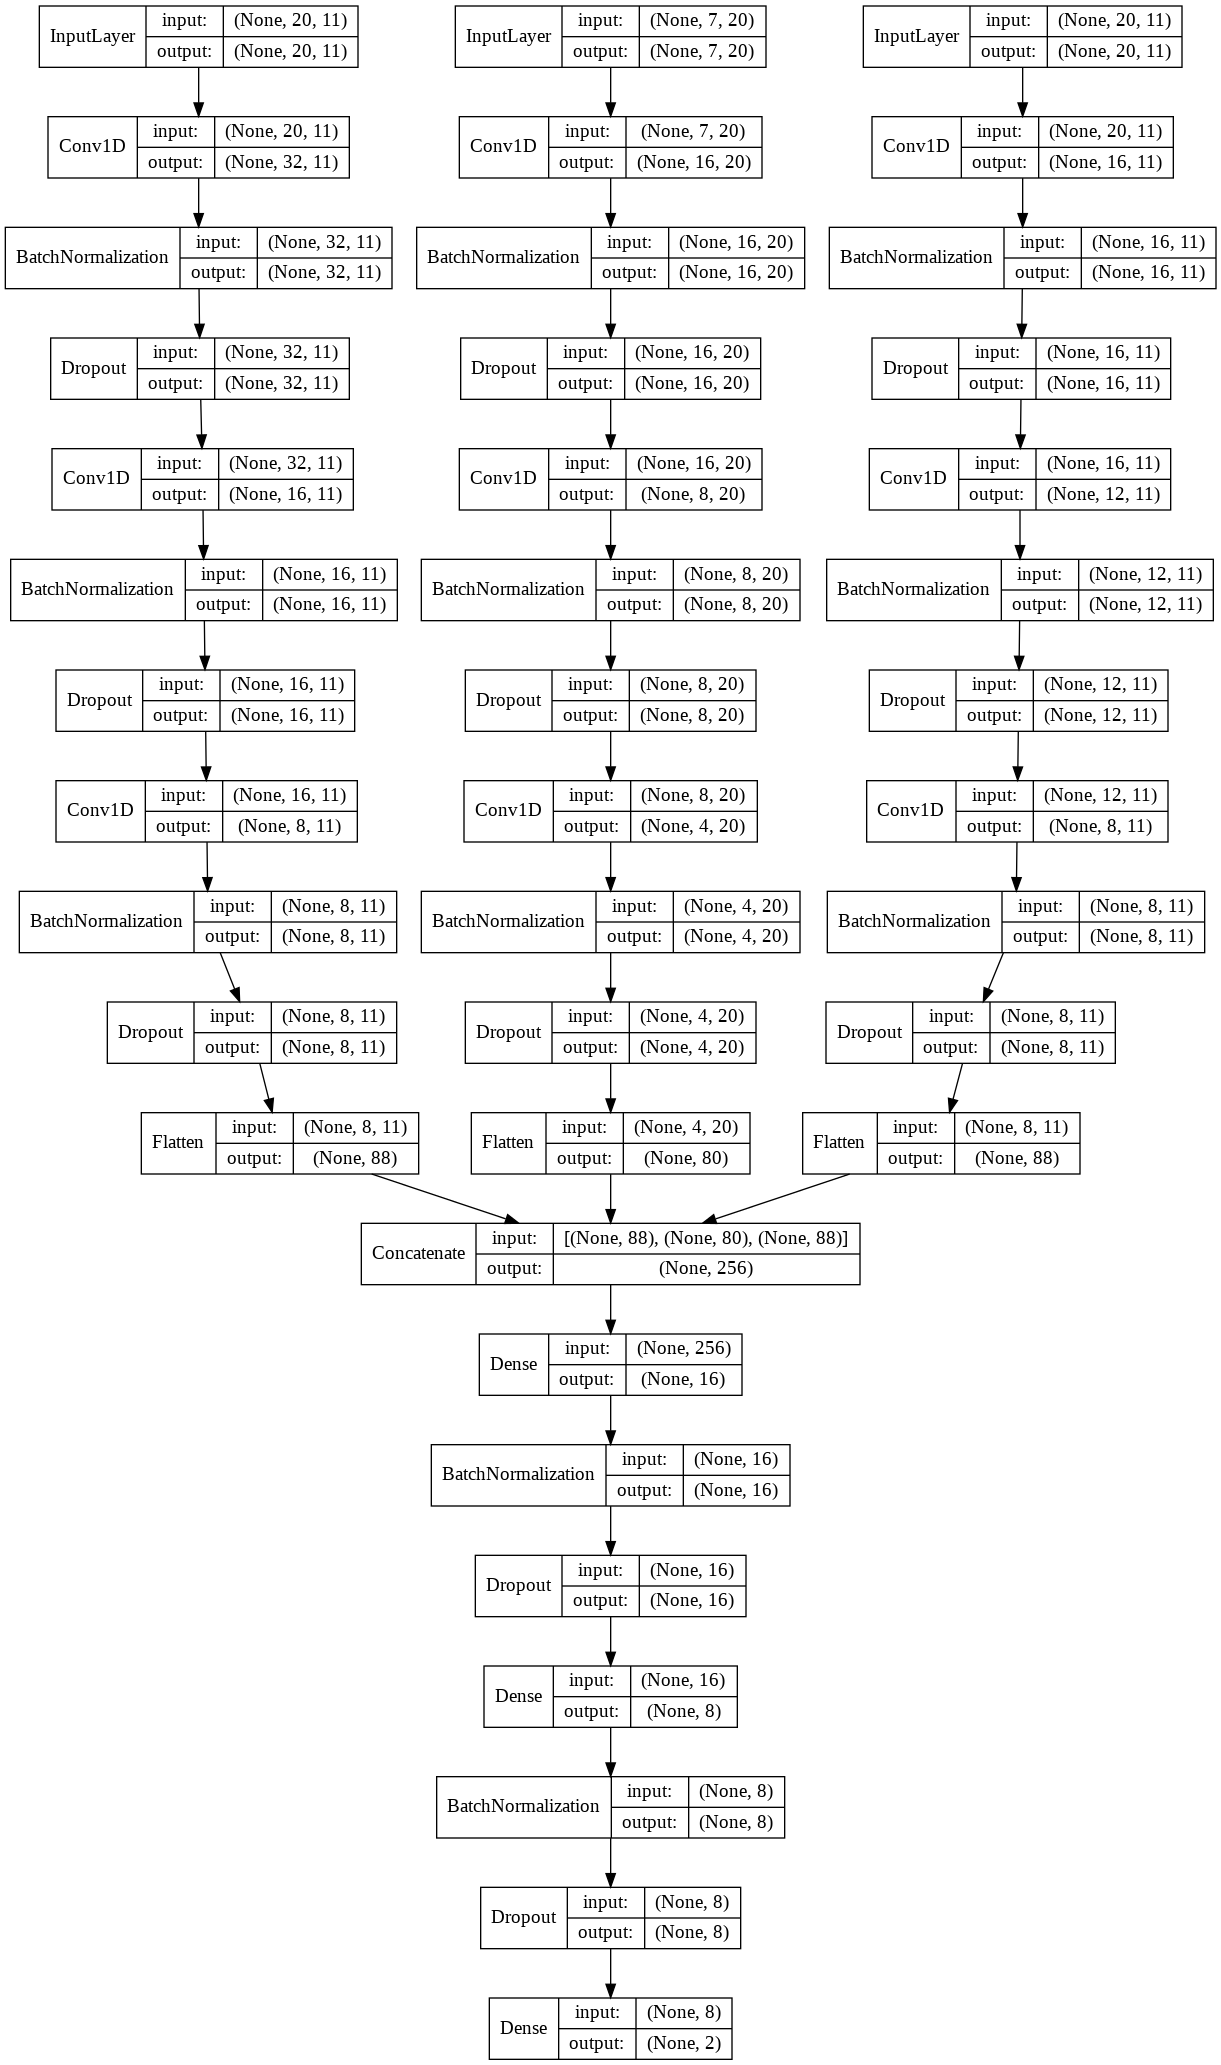

In [32]:
model = Network()
model.summary()
plot_model(model, to_file='model-500-164.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [0]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['acc'], label='Training Accuracy')
    plt.plot(results.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

## Set Epoch and Batch Size:

In [0]:
setEpochNumber     = 3000     # 2,500 performed well.
setBatchSizeNumber = 16

## 6. Run Model:

Streaming output truncated to the last 5000 lines.
Epoch 503/3000
500/500 [==============================] - 0s 580us/step - loss: 0.6664 - acc: 0.5820 - val_loss: 0.6563 - val_acc: 0.6707
Epoch 504/3000
500/500 [==============================] - 0s 574us/step - loss: 0.6913 - acc: 0.5480 - val_loss: 0.6559 - val_acc: 0.6707
Epoch 505/3000
500/500 [==============================] - 0s 591us/step - loss: 0.6937 - acc: 0.5660 - val_loss: 0.6549 - val_acc: 0.6646
Epoch 506/3000
500/500 [==============================] - 0s 573us/step - loss: 0.6906 - acc: 0.5520 - val_loss: 0.6548 - val_acc: 0.6646
Epoch 507/3000
500/500 [==============================] - 0s 562us/step - loss: 0.6867 - acc: 0.5920 - val_loss: 0.6554 - val_acc: 0.6707
Epoch 508/3000
500/500 [==============================] - 0s 567us/step - loss: 0.6788 - acc: 0.5800 - val_loss: 0.6548 - val_acc: 0.6707
Epoch 509/3000
500/500 [==============================] - 0s 562us/step - loss: 0.6942 - acc: 0.5880 - val_loss: 0.6549 -

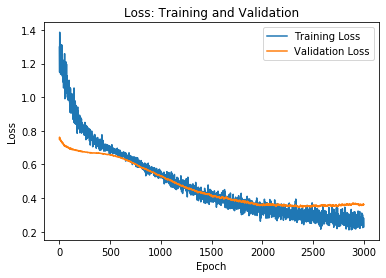

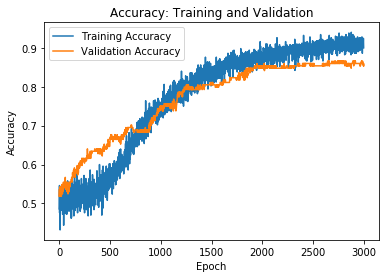

#################################################
[0.8536585365853658]
Accuracy: 0.17
Sensitivity: 0.1927
Specificity: 0.1488
MCC: 0.1450
Precision: 0.1580


In [43]:
Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# CM = np.array([
#      [0, 0],
#      [0, 0],
# ], dtype=int)


# Compile Model:
model = Network()
model.compile(optimizer=Adam(lr=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Run Model:
results = model.fit(x=[X1train, X2train, X3train], y=[Ytrain], validation_data=([X1test, X2test, X3test], [Ytest]), epochs=setEpochNumber, batch_size=setBatchSizeNumber, verbose=1)

# Evaluate the Model:
accuracy = model.evaluate(x=[X1test, X2test, X3test], y=Ytest)
Accuracy.append(accuracy[1])

# Performance Metices:
Yactual = Ytest.argmax(axis=1)
Yp = model.predict([X1test, X2test, X3test])
Yp = Yp.argmax(axis=1)

CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
TN, FP, FN, TP = CM.ravel()

MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
Sensitivity.append( TP / (TP + FN) )
Specificity.append( TN / (TN + FP) )
Precision.append(precision_score(y_true=Yactual, y_pred=Yp))


# Performance Plot
print('#################################################')
print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
lossPlot(results)
accuracyPlot(results)
print('#################################################')

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))

In [0]:
model.save('500-164.h5')